# Spindles detection

This notebook demonstrates how to use YASA to perform **single-channel sleep spindles detection**. It also shows a step-by-step description of the detection algorithm.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

## Single-channel spindles detection
As an example, we load 15 seconds of N2 sleep on a single
channel central EEG data. The sampling rate is 200 Hz.

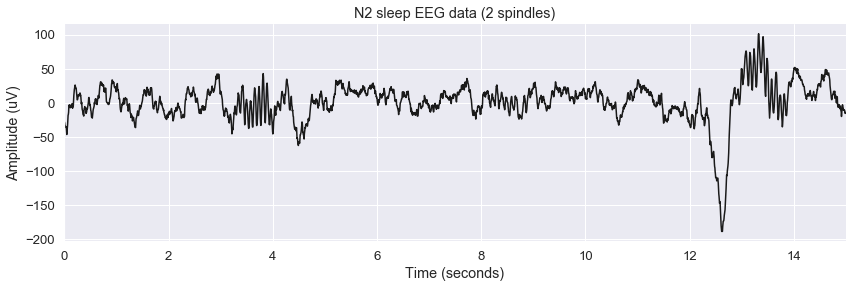

In [2]:
# Load data
data = np.loadtxt('data_N2_spindles_15sec_200Hz.txt')

# Define sampling frequency and time vector
sf = 200.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N2 sleep EEG data (2 spindles)')
sns.despine()

We can clearly see that there are two clean spindles on this 15-seconds epoch. The first one starting at around 3.5 seconds and the second one starting around 13 seconds.

Let's try to detect these two spindles using the [yasa.spindles_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html) function. Here' we're using a minimal example, but there are many other optional arguments that you can pass to this function.

In [3]:
# Apply the detection using yasa.spindles_detect
sp = yasa.spindles_detect(data, sf)

# Display the results using .summary()
sp.summary()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,3.24,3.815,4.060,0.820,82.372425,19.130129,2.685120,0.480513,12.851043,11.0,0.696970,CHAN000,0
1,13.06,13.410,13.845,0.785,102.758017,23.991812,2.832498,0.226470,12.245327,10.0,0.443038,CHAN000,0


Hooray! The algorithm successfully identified the two spindles! 

The output of the spindles detection is a [SpindlesResults](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults) class, which comes with some pre-compiled functions (also called methods). For instance, the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.summary) method returns a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) with all the detected spindles and their properties.

### Plot an overlay of our detected spindles

First we need to create a boolean array of the same size of data indicating for each sample if this sample is part of a spindles or not. This is done using the [get_mask](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.get_mask) method:

In [4]:
# Let's get a bool vector indicating for each sample
mask = sp.get_mask()
mask

array([0, 0, 0, ..., 0, 0, 0])

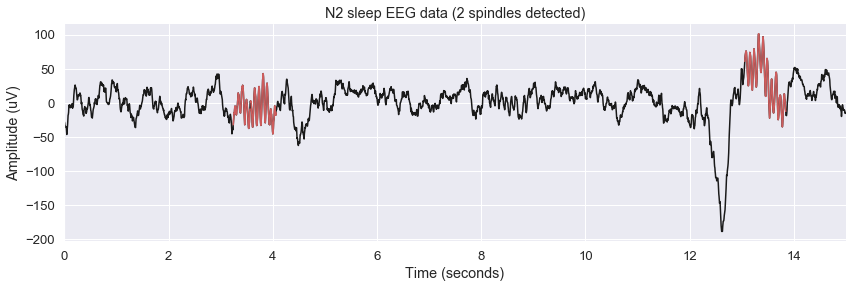

In [5]:
# Now let's plot
spindles_highlight = data * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N2 sleep EEG data (2 spindles detected)')
sns.despine()
# plt.savefig('detection.png', dpi=300, bbox_inches='tight')

### Logging

YASA uses the [logging](https://docs.python.org/3/library/logging.html) module to selectively print relevant messages. The default level of the logger is set to "WARNING", which means that a message will only be displayed if a warning occurs. However, you can easily set this parameter to "INFO" to get some relevant infos about the detection pipeline and the data.

This can be useful to debug the detection and/or if you feel that the detection is not working well on your data.

In [6]:
# The default verbose is None which corresponds to verbose='warning'
sp = yasa.spindles_detect(data, sf, thresh={'rms': None}, verbose='info')
sp.summary()

09-May-20 10:00:55 | INFO | Number of samples in data = 3000
09-May-20 10:00:55 | INFO | Sampling frequency = 200.00 Hz
09-May-20 10:00:55 | INFO | Data duration = 15.00 seconds
09-May-20 10:00:55 | INFO | Trimmed standard deviation of CHAN000 = 15.5869 uV
09-May-20 10:00:55 | INFO | Peak-to-peak amplitude of CHAN000 = 289.6042 uV
09-May-20 10:00:55 | INFO | N supra-theshold relative power = 313
09-May-20 10:00:55 | INFO | N supra-theshold moving corr = 345


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,3.20,3.815,4.095,0.895,84.424171,19.504900,2.648972,0.464375,12.849625,11.0,0.683333,CHAN000,0
1,13.06,13.410,13.840,0.780,102.751826,24.067959,2.834379,0.226988,12.245316,10.0,0.445860,CHAN000,0


### Safety check

To make sure that our spindle detection does not detect false positives, let's load a new dataset, this time without any sleep spindles. The data represents 30 seconds of N3 sleep sampled at 100 Hz and acquired on a young, healthy, individual.

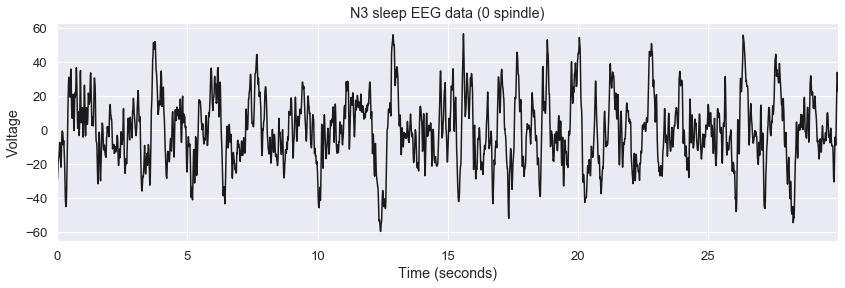

In [7]:
data_no_sp = np.loadtxt('data_N3_no-spindles_30sec_100Hz.txt')
sf_no_sp = 100
times_no_sp = np.arange(data_no_sp.size) / sf_no_sp

plt.figure(figsize=(14, 4))
plt.plot(times_no_sp, data_no_sp, 'k')
plt.xlim(0, times_no_sp.max())
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([times_no_sp.min(), times_no_sp.max()])
plt.title('N3 sleep EEG data (0 spindle)')
sns.despine()

In [8]:
sp = yasa.spindles_detect(data_no_sp, sf_no_sp)
sp

09-May-20 10:00:56 | WARNING | No spindle were found in channel CHAN000.
09-May-20 10:00:56 | WARNING | No spindles were found in data. Returning None.


As hoped for, no spindles were detected in this window.

### Execution time

The total execution time on a regular laptop is 10-20 ms per 15 seconds of data sampled at 200 Hz. Scaled to a full night recording, the computation time should not exceed 5-10 seconds per channel on any modern computers. Furthermore, it is possible to disable one or more threshold and thus speed up the computation. Note that most of the computation cost is dominated by the bandpass filter(s).

In [9]:
%timeit -r 3 -n 100 yasa.spindles_detect(data, sf)

11.8 ms ± 430 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [10]:
%timeit -r 3 -n 100 yasa.spindles_detect(data, sf, thresh={'rms': 3, 'corr': None, 'rel_pow': None})

10.3 ms ± 221 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [11]:
# Line profiling
# %load_ext line_profiler
# %lprun -f yasa.spindles_detect yasa.spindles_detect(data, sf)

****************

## The YASA spindles algorithm: step-by-step

The YASA spindles algorithm is largely inspired by the A7 algorithm described in [Lacourse et al. 2018](https://doi.org/10.1016/j.jneumeth.2018.08.014):

> Lacourse, K., Delfrate, J., Beaudry, J., Peppard, P., Warby, S.C., 2018. A sleep spindle detection algorithm that emulates human expert spindle scoring. *J. Neurosci. Methods*. https://doi.org/10.1016/j.jneumeth.2018.08.014

The main idea of the algorithm is to compute different thresholds from the broadband-filtered signal (1 to 30Hz, $\text{EEG}_{bf}$) and the sigma-filtered signal (11 to 16 Hz, $\text{EEG}_{\sigma}$).

**There are some notable exceptions between YASA and the A7 algorithm:**
1. YASA uses 3 different thresholds (relative $\sigma$ power, [root mean square](https://en.wikipedia.org/wiki/Root_mean_square) and correlation). The A7 algorithm uses 4 thresholds (absolute and relative $\sigma$ power, covariance and correlation). Note that it is possible in YASA to disable one or more threshold by putting ``None`` instead.
2. The windowed detection signals are resampled to the original time vector of the data using cubic interpolation, thus resulting in a pointwise detection signal (= one value at every sample). The time resolution of YASA is therefore higher than the A7 algorithm. This allows for more precision to detect the beginning, end and durations of the spindles (typically, A7 = 100 ms and YASA = 10 ms).
3. The relative power in the sigma band is computed using a Short-Term Fourier Transform. The relative sigma power is not z-scored.
4. The median frequency and absolute power of each spindle is computed using an Hilbert transform.
5. YASA computes some additional spindles properties, such as the symmetry index and number of oscillations. These metrics are inspired from [Purcell et al. 2017](https://www.nature.com/articles/ncomms15930).
7. Potential sleep spindles are discarded if their duration is below 0.5 seconds and above 2 seconds. These values are respectively 0.3 and 2.5 seconds in the A7 algorithm.
8. YASA incorporates an automatic rejection of pseudo or fake events based on an [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) algorithm.

### Preprocessing

The raw signal is bandpass filtered to the broadband frequency range defined in the (optional) parameter `freq_broad`. The default is to use a FIR filter from 1 to 30 Hz. The filter is done using the MNE built-in [filter_data](https://martinos.org/mne/stable/generated/mne.filter.filter_data.html) function. The resulting, filtered, signal is $\text{EEG}_{bf}$.

In [12]:
from mne.filter import resample, filter_data

# Broadband (1 - 30 Hz) bandpass filter
freq_broad = (1, 30)
data_broad = filter_data(data, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0)

### Threshold 1: Relative power in the sigma band

The first detection signal is the power in the sigma frequency range (11-16 Hz) relative to the total power in the broadband frequency (1-30 Hz). This is calculated using a [Short-Term Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT) on consecutive epochs of 2 seconds and with an overlap of 200 ms. The first threshold is exceeded whenever a sample has a relative power in the sigma frequency range $\geq 0.2$. In other words, it means that 20% of the signal's total power must be contained within the sigma band. The goal of this threshold is to make sure that the increase in sigma power is actually specific to the sigma frequency range and not just due to a global increase in power (e.g. caused by artefacts).

Importantly, you may want to lower this threshold if you aim to detect spindles in N3 sleep (slow-wave sleep), a sleep stage in which most of the relative spectral power is contained in the delta band (0.5 to 4 Hz). 

#### More about the STFT

Because our STFT has a window of 2 seconds, it means that our frequency resolution is $1 / 2 = 0.5$ Hz. In other words, our frequency vector is *[1, 1.5, 2, ..., 29, 29.5, 30]* Hz. The power in the sigma frequency range is simply the sum, at each time point, of the power values at $f_{\sigma}=$*[11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16]* Hz.

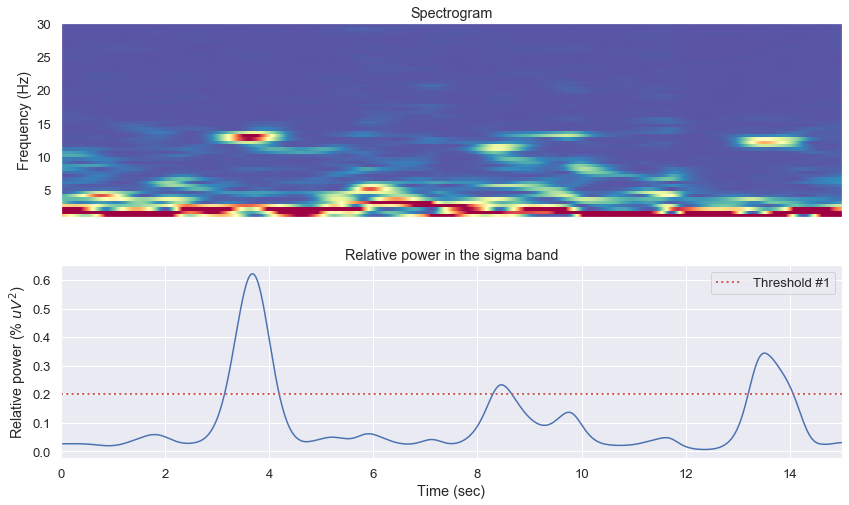

In [13]:
# Compute the pointwise relative power using STFT and cubic interpolation
f, t, Sxx = yasa.main.stft_power(data_broad, sf, window=2, step=.2, band=freq_broad, norm=True, interp=True)

# Extract the relative power in the sigma band
idx_sigma = np.logical_and(f >= 11, f <= 16)
rel_pow = Sxx[idx_sigma].sum(0)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=.25)
im = ax1.pcolormesh(t, f, Sxx, cmap='Spectral_r', vmax=0.2)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax2.plot(t, rel_pow)
ax2.set_ylabel('Relative power (% $uV^2$)')
ax2.set_xlim(t[0], t[-1])
ax2.set_xlabel('Time (sec)')
ax2.axhline(0.20, ls=':', lw=2, color='indianred', label='Threshold #1')
plt.legend()
_ = ax2.set_title('Relative power in the sigma band')

### Threshold 2: Moving correlation

For the two remaining thresholds, we are going to need the sigma-filtered signal ($\text{EEG}_{\sigma}$). Here again, we use the MNE built-in [FIR filter](https://martinos.org/mne/stable/generated/mne.filter.filter_data.html). Note that we use a FIR filter and not a IIR filter because *"FIR filters are easier to control, are always stable, have a well-defined passband, and can be corrected to zero-phase without additional computations"* ([Widmann et al. 2015](https://doi.org/10.1016/j.jneumeth.2014.08.002)).

The default sigma bandpass filtering in YASA uses a 12 to 15 Hz zero-phase FIR filtering with transition bands of 1.5 Hz at each side. The - 6dB cutoff is therefore defined at 11.25 Hz and 15.75 Hz.

Please refer to the [MNE documentation](https://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html#sphx-glr-auto-tutorials-plot-background-filtering-py) for more details on filtering.

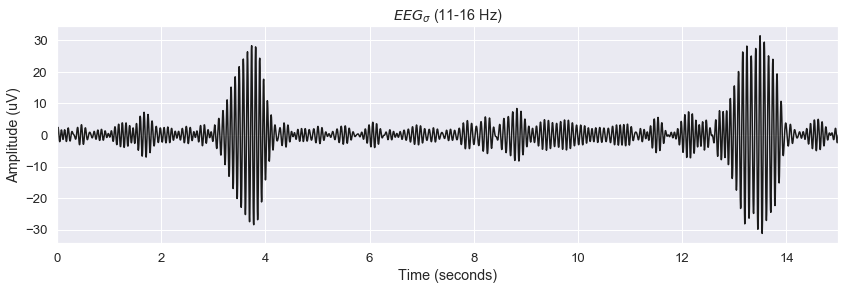

In [14]:
data_sigma = filter_data(data, sf, 12, 15, l_trans_bandwidth=1.5, 
                         h_trans_bandwidth=1.5, method='fir', verbose=0)

# Plot the filtered signal
plt.figure(figsize=(14, 4))
plt.plot(times, data_sigma, 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.title('$EEG_{\sigma}$ (11-16 Hz)')
_ = plt.xlim(0, times[-1])

Our second detection signal is calculated by taking, with a moving sliding window of 300 ms and a step of 100 ms, the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between and $\text{EEG}_{bf}$ and $\text{EEG}_{\sigma}$. According to [Lacourse et al. 2018](http://dx.doi.org/10.1016/j.jneumeth.2018.08.014):

> The current spindle detector design is unique because it uses a correlation filter between the EEG signal filtered in the sigma band and the raw EEG signal itself. The proposed design is therefore biased to detect spindles that are visible on the raw EEG signal by requiring a high correlation between raw EEG signal and the filtered sigma burst (the pattern that represents a spindle).

Once again, the values are interpolated using cubic interpolation to obtain one value per each time point. The second threshold is exceeded whenever a sample has a correlation value $r \geq .65$.

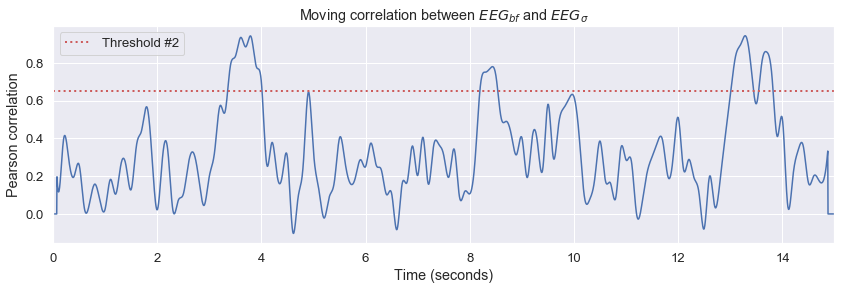

In [15]:
t, mcorr = yasa.main.moving_transform(data_sigma, data_broad, sf, window=.3, step=.1, method='corr', interp=True)

plt.figure(figsize=(14, 4))
plt.plot(times, mcorr)
plt.xlabel('Time (seconds)')
plt.ylabel('Pearson correlation')
plt.axhline(0.65, ls=':', lw=2, color='indianred', label='Threshold #2')
plt.legend()
plt.title('Moving correlation between $EEG_{bf}$ and $EEG_{\sigma}$')
_ = plt.xlim(0, times[-1])

### Threshold 3: Moving RMS

The third and last threshold is defined by computing a moving [root mean square](https://en.wikipedia.org/wiki/Root_mean_square) (RMS) of $\text{EEG}_{\sigma}$, with a window size of 300 ms and a step of 100 ms. The purpose of this threshold is simply to detect increase of energy in the $\text{EEG}_{\sigma}$ signal. As before, the values are interpolated using cubic interpolation to obtain one value per each time point. The third threshold is exceeded whenever a sample has a $\text{RMS} \geq \text{RMS}_{\text{thresh}}$, the latter being defined as:

$\text{RMS}_{\text{thresh}} = \text{RMS}_{\text{mean}} + 1.5 \times \text{RMS}_{\text{std}}$

Note that the 10% lowest and 10% highest values are removed from the RMS signal before computing the standard deviation ($\text{RMS}_{\text{std}}$). This reduces the bias caused by potential artifacts and/or extreme values.

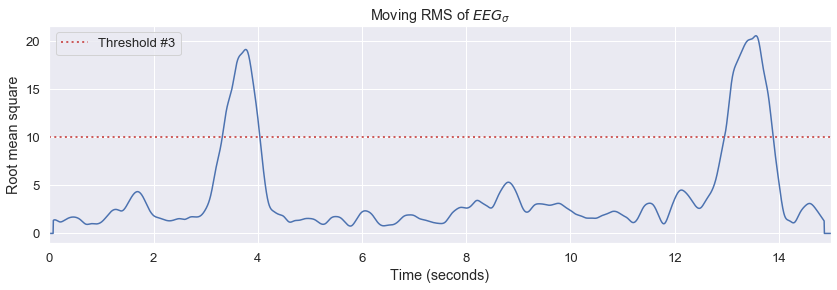

In [16]:
t, mrms = yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='rms', interp=True)

# Define threshold
trimmed_std = yasa.main.trimbothstd(mrms, cut=0.025)
thresh_rms = mrms.mean() + 1.5 * trimmed_std

plt.figure(figsize=(14, 4))
plt.plot(times, mrms)
plt.xlabel('Time (seconds)')
plt.ylabel('Root mean square')
plt.axhline(thresh_rms, ls=':', lw=2, color='indianred', label='Threshold #3')
plt.legend()
plt.title('Moving RMS of $EEG_{\sigma}$')
_ = plt.xlim(0, times[-1])

### Decision function
Every sample of the data that validate all 3 thresholds is considered as a potential sleep spindle. However, the detection using the three thresholds tends to underestimate the real duration of the spindle. To overcome this, we compute a soft threshold by smoothing the decision vector with a 100 ms window. We then find indices in the decision vector that are strictly greater than 2. In other words, we find
the *true* beginning and *true* end of the events by finding the indices at which two out of the three treshold were crossed.

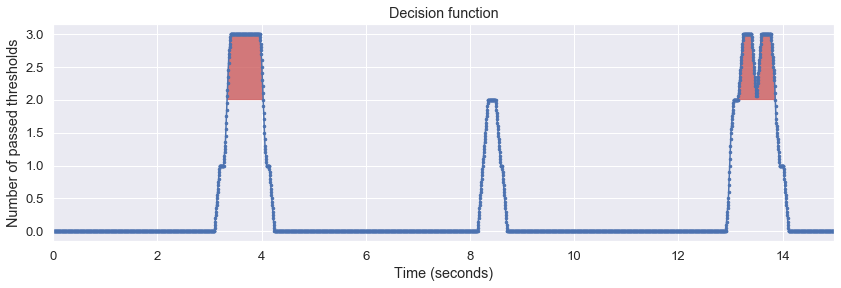

In [17]:
# Combine all three threholds
idx_rel_pow = (rel_pow >= 0.2).astype(int)
idx_mcorr = (mcorr >= 0.65).astype(int)
idx_mrms = (mrms >= 10).astype(int)
idx_sum = (idx_rel_pow + idx_mcorr + idx_mrms).astype(int)

# Soft threshold
w = int(0.1 * sf)
idx_sum = np.convolve(idx_sum, np.ones(w) / w, mode='same')

plt.figure(figsize=(14, 4))
plt.plot(times, idx_sum, '.-', markersize=5)
plt.fill_between(times, 2, idx_sum, where=idx_sum > 2, color='indianred', alpha=.8)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of passed thresholds')
plt.title('Decision function')
_ = plt.xlim(0, times[-1])

### Morphological criteria

Now that we have our potential spindles candidates, we apply two additional steps to optimize the detection:
1. Spindles that are too close to each other (less than 500 ms) are merged together
2. Spindles that are either too short ($<0.5$ sec) or too long ($>2$ sec) are removed.

In [18]:
where_sp = np.where(idx_sum > 2)[0]

# Merge events that are too close together
where_sp = yasa.main._merge_close(where_sp, 500, sf)

# Extract start, end, and duration of each spindle
sp = np.split(where_sp, np.where(np.diff(where_sp) != 1)[0] + 1)
idx_start_end = np.array([[k[0], k[-1]] for k in sp]) / sf
sp_start, sp_end = idx_start_end.T
sp_dur = sp_end - sp_start

# Find events with good duration
good_dur = np.logical_and(sp_dur > 0.5, sp_dur < 2)

print(sp_dur, good_dur)

[0.69  0.145 0.795] [ True False  True]


### Spindles properties
From then, we can be pretty confident that our detected spindles are actually *true* sleep spindles.

The last step of the algorithm is to extract, for each individual spindle, several properties:
- Start and end time in seconds
- Duration (seconds)
- Amplitude ($\mu V$)
- Root mean square ($\mu V$)
- Median absolute power ($\log_{10} \mu V^2$)
- Median relative power (from 0 to 1, % $\mu V^2$)
- Median frequency (Hz, extracted with an Hilbert transform)
- Number of oscillations
- Index of the most prominent peak (in seconds)
- Symmetry (indicates where is the most prominent peak on a 0 to 1 vector where 0 is the beginning of the spindles and 1 the end. Ideally it should be around 0.5)

In the example below, we plot the two detected spindles and compute the peak-to-peak amplitude of the spindles.
To see how the other properties are computed, please refer to the [source code](https://github.com/raphaelvallat/yasa/blob/master/yasa/main.py) of the `spindles_detect` function.

Peak-to-peak amplitude:	 [ 85.2111293    0.         106.32701275]


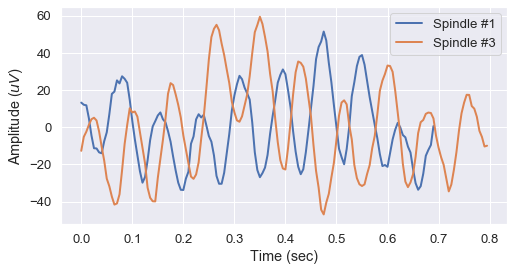

In [19]:
from scipy.signal import detrend

sp_amp = np.zeros(len(sp))

plt.figure(figsize=(8, 4))

for i in np.arange(len(sp))[good_dur]:
    # Important: detrend the spindle signal to avoid wrong peak-to-peak amplitude
    sp_det = detrend(data[sp[i]], type='linear')
    
    # Now extract the peak to peak amplitude
    sp_amp[i] = np.ptp(sp_det)  # Peak-to-peak amplitude

    # And plot the spindles
    plt.plot(np.arange(sp_det.size) / sf, sp_det,
             lw=2, label='Spindle #' + str(i+1))

plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude ($uV$)')

print('Peak-to-peak amplitude:\t', sp_amp)